In [ ]:
#Looking at the vegetation indices

In [6]:
#determine the vegetation type for each pixel
#add in overall landcover type based on 5 nearest neighbours

#Manual entries
CITY_COUNTRY = "HUAMBO_ANGOLA"

SATELLITE = 'MOD11A2' #TERRA
#SATELLITE = 'MYD11A2' #AQUA

In [7]:
#Import packages
import os
import re  # regular expressions for getting lat lon grid
import pathlib
import warnings
import gdal
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio as rio # for extracting subsets
from rasterio.plot import plotting_extent #for plotting
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
import pandas as pd
import pickle
import matplotlib.patches as mpatches

#for the reprojecting
import pyproj
from pyproj import CRS
from pyproj import Transformer
import cartopy
import cartopy.crs as ccrs
from shapely.geometry import Point, LineString, Polygon
from pyhdf.SD import SD, SDC
import datetime as dt
import scipy
from scipy import interpolate
import geopandas as gpd

#for finding the mode
from collections import Counter

#load in csv of city lons and lats
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))

CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx')
#drop the rows for the cities not looking at, reset index after dropping, drop old index
#CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon.drop([9,11,18,22,23]).reset_index(drop = True)

#Identify names/ values of chosen city
#set the city latitude and longitudes and city name
City_Lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lat'].values[0]
City_Lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lon'].values[0]
City_name = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City'].values[0]
City_area = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Area'].values[0]
City_bound_xmin = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_xmin'].values[0]/1000
City_bound_xmax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_xmax'].values[0]/1000
City_bound_ymin = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_ymin'].values[0]/1000
City_bound_ymax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_ymax'].values[0]/1000
#city extent bound used as constraint. Used 2*sqrt(city_area) +2
City_extent_bound = 2*np.sqrt(City_area) + 2


#Area to look at will be the city centre +/- 0.2 degs
min_lat = City_Lat - 0.2
max_lat = City_Lat + 0.2
min_lon = City_Lon - 0.2
max_lon = City_Lon + 0.2


#create satellite name for plots
if SATELLITE == 'MOD11A2':
    satellite_name = 'Terra'
else:
    satellite_name = 'Aqua'
    
#Load in LULC data, these bases were created in JASMIN
with open('UHI_Project_Pickle_Files\LULC_Pickles\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
     LULC_df = pickle.load(f)

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [90]:
#Vegetation indices

#function to extract the subdatasets of interest and return a dataframe 
#NDVI and EVI are vegetation indices
#pixel reliability and VI quality are the quality checks

#function to create the vegetation indices (VIs) dataframe 
def vi_dataframe_create(SATELLITE_NDVI, vi_file_name):
    #set to directory with files
    os.chdir(os.path.join('D:\\','MODIS_NDVI', CITY_COUNTRY, SATELLITE_NDVI))
    #path to the file
    data_path = os.path.join('D:\\','MODIS_NDVI', CITY_COUNTRY, SATELLITE_NDVI, vi_file_name)
    with rio.open(data_path) as dataset:
    # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has NDVI in the name
            if re.search("1 km monthly NDVI", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    NDVI = subdataset.read(1)
                
            # Use regular expression to identify if subdataset has EVI in the name
            if re.search("1 km monthly EVI", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    EVI = subdataset.read(1)
                
       
            # Use regular expression to identify if subdataset has reliability in the name (for pixel reliability)
            if re.search("1 km monthly pixel reliability", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    pixel_reliability = subdataset.read(1)
                
                
              # Use regular expression to identify if subdataset has quality in the name (for VI Quality)
            if re.search("1 km monthly VI Quality", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    VI_quality = subdataset.read(1)       
                
                
    #Create the coordinate grid
    # Identify the data field- use the NDVI field but grid is same for all data
    DATAFIELD_NAME = '1 km monthly EVI'

    if SATELLITE_NDVI == 'MOD13A3':
        GRID_NAME = 'MOD_Grid_monthly_1km_VI'
    else:
        GRID_NAME = 'MYD_Grid_monthly_1km_VI'
        
    hdf = SD(vi_file_name, SDC.READ)

    # Read dataset.
    data2D = hdf.select(DATAFIELD_NAME)
    data = data2D[:,:].astype(np.float64)

    # Read global attribute.
    fattrs = hdf.attributes(full=1)
    ga = fattrs["StructMetadata.0"]
    gridmeta = ga[0]

    # Construct the grid.  Required information in global attribute called 'StructMetadata.0'

    ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                                  (?P<upper_left_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<upper_left_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = ul_regex.search(gridmeta)
    x0 = np.float(match.group('upper_left_x')) 
    y0 = np.float(match.group('upper_left_y')) 

    lr_regex = re.compile(r'''LowerRightMtrs=\(
                                  (?P<lower_right_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<lower_right_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = lr_regex.search(gridmeta)
    x1 = np.float(match.group('lower_right_x')) 
    y1 = np.float(match.group('lower_right_y')) 
    ny, nx = data.shape
    xinc = (x1 - x0) / nx
    yinc = (y1 - y0) / ny

    x = np.linspace(x0, x0 + xinc*nx, nx)
    y = np.linspace(y0, y0 + yinc*ny, ny)
    xv, yv = np.meshgrid(x, y)

    # convert the grid back to lat/lons.
    transformer = Transformer.from_crs("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext", "EPSG:4326")
    lat, lon = transformer.transform(xv, yv)

    #Apply scale factors
    scale_factor_NDVI = 0.0001
    scale_factor_EVI = 0.0001

    NDVI = NDVI*scale_factor_NDVI
    EVI = EVI*scale_factor_EVI

    #Create the lists to be combined to create a dataframe
    NDVI_list = NDVI.flatten()
    EVI_list = EVI.flatten()
    pixel_reliability_list = pixel_reliability.flatten()
    VI_quality_list = VI_quality.flatten()
    Lon_list = lon.flatten()
    Lat_list = lat.flatten()

    #Create the dataframe

    df = pd.DataFrame(list(zip(NDVI_list, EVI_list, pixel_reliability_list, VI_quality_list, Lon_list, Lat_list)), 
               columns =['NDVI', 'EVI','pixel_reliability', 'VI_quality','Longitude', 'Latitude']) 

    #Create dataframe of the required area
    City_Lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lat'].values[0]
    City_Lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lon'].values[0]
    min_lat = City_Lat - 0.2
    max_lat = City_Lat + 0.2
    min_lon = City_Lon - 0.2
    max_lon = City_Lon + 0.2
    
    df_subset = df[(df.Latitude > min_lat) & (df.Latitude < max_lat) & (df.Longitude > min_lon) & (df.Longitude < max_lon)]
    
    return df_subset

In [15]:
#file to view the subdatasets in the ndvi files

os.chdir(os.path.join('D:\\','MODIS_NDVI', CITY_COUNTRY, 'MYD13A3'))

# Open file.
FILE_NAME = 'MYD13A3.A2020275.h19v10.006.2020315004016.hdf'
hdf = SD(FILE_NAME, SDC.READ)

# List available SDS datasets.
print (hdf.datasets())

{'1 km monthly NDVI': (('YDim:MOD_Grid_monthly_1km_VI', 'XDim:MOD_Grid_monthly_1km_VI'), (1200, 1200), 22, 0), '1 km monthly EVI': (('YDim:MOD_Grid_monthly_1km_VI', 'XDim:MOD_Grid_monthly_1km_VI'), (1200, 1200), 22, 1), '1 km monthly VI Quality': (('YDim:MOD_Grid_monthly_1km_VI', 'XDim:MOD_Grid_monthly_1km_VI'), (1200, 1200), 23, 2), '1 km monthly red reflectance': (('YDim:MOD_Grid_monthly_1km_VI', 'XDim:MOD_Grid_monthly_1km_VI'), (1200, 1200), 22, 3), '1 km monthly NIR reflectance': (('YDim:MOD_Grid_monthly_1km_VI', 'XDim:MOD_Grid_monthly_1km_VI'), (1200, 1200), 22, 4), '1 km monthly blue reflectance': (('YDim:MOD_Grid_monthly_1km_VI', 'XDim:MOD_Grid_monthly_1km_VI'), (1200, 1200), 22, 5), '1 km monthly MIR reflectance': (('YDim:MOD_Grid_monthly_1km_VI', 'XDim:MOD_Grid_monthly_1km_VI'), (1200, 1200), 22, 6), '1 km monthly view zenith angle': (('YDim:MOD_Grid_monthly_1km_VI', 'XDim:MOD_Grid_monthly_1km_VI'), (1200, 1200), 22, 7), '1 km monthly sun zenith angle': (('YDim:MOD_Grid_monthl

In [15]:
#get lists of all the VI files and their months/ years
#TERRA
SATELLITE_NDVI = 'MOD13A3'
os.chdir(os.path.join('D:\\','MODIS_NDVI', CITY_COUNTRY, SATELLITE_NDVI))

file_list = []
month_list = []
year_list = []
for filename in os.listdir():
    if filename.endswith(".hdf"): 
        file_list.append(filename)
        yeardoy = filename.split('.')[1][1:]
        month_list.append(dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m'))
        year_list.append(dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y'))
        continue
    else:
        continue

d = {'Filename': file_list, 'Month': month_list, 'Year': year_list}
vi_look_up_terra = pd.DataFrame(data = d)

#AQUA
SATELLITE_NDVI = 'MYD13A3'
os.chdir(os.path.join('D:\\','MODIS_NDVI', CITY_COUNTRY, SATELLITE_NDVI))

file_list = []
month_list = []
year_list = []
for filename in os.listdir():
    if filename.endswith(".hdf"): 
        file_list.append(filename)
        yeardoy = filename.split('.')[1][1:]
        month_list.append(dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m'))
        year_list.append(dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y'))
        continue
    else:
        continue

d = {'Filename': file_list, 'Month': month_list, 'Year': year_list}
vi_look_up_aqua = pd.DataFrame(data = d)      


In [24]:
#extract the date of each image
#add the ndvi/ evi into the gsa code and perform linear regession-ndvi rur, urb. overall ndvi, evi rur, urb. save parameters

#create an average NDVI/ EVI map for each month
#which months are greener/ how does NDVI/ EVI vary throughout the year 

#investigating the qc/ reliability flags
#convert to binary
def generate_qc_flags(vi_df):
    vi_df['VI_binary'] = ["{0:b}".format(vi_df.VI_quality.iloc[x]) for x in range(len(vi_df))]

    quality_list = []

    for i in range(len(vi_df)):
        binary = vi_df.VI_binary.iloc[i]    
        if binary[0] == '0' and binary[1] == '0':
            Quality = 'Good'
        elif binary[0] == '0' and binary[1] == '1':
            Quality = 'Check'
        elif binary[0] == '1' and binary[1] == '0':
            Quality = 'Poor cloud'
        elif binary[0] == '1' and binary[1] == '1':
            Quality = 'Poor not cloud'
        else: 
            Quality = 'Error'
    
        quality_list.append(Quality)
    
    
    usefulness_list = []
    for i in range(len(vi_df)):
        binary = vi_df.VI_binary.iloc[i] 
        if binary[2:6] == '0000':
            Use = '0' #
        elif binary[2:6] == '0001':
            Use = '1' 
        elif binary[2:6] == '0010':
            Use = '2'
        elif binary[2:6] == '0100':
            Use = '3' 
        elif binary[2:6] == '1000':
            Use = '4' 
        elif binary[2:6] == '1001':
            Use = '5' 
        elif binary[2:6] == '1010':
            Use = '6' 
        elif binary[2:6] == '1100':
            Use = '7'    
        elif binary[2:6] == '0110' or binary[2:6] == '0101' or binary[2:6] == '0111': #not included in key for some reason?
            Use = '8'
        elif binary[2:6] == '0011': #not included in key for some reason?
            Use = '9'    
        elif binary[2:6] == '1101' or binary[2:6] == '1110' or binary[2:6] == '1111': 
            Use = 'No Use'
        else:
            Use = 'Error'
        usefulness_list.append(Use)
    
    pixel_reliable_count = len(vi_df[vi_df['pixel_reliability'] == 0])
    good_quality = quality_list.count('Good')
    check_quality = quality_list.count('Check')
    usefulness_0 = usefulness_list.count('0')
    usefulness_1 = usefulness_list.count('1')
    
    return [pixel_reliable_count, good_quality, check_quality, usefulness_0, usefulness_1]
        
#vi_df['Quality_Check'] = quality_list
#vi_df['Usefulness'] = usefulness_list

In [17]:
#vi_df = vi_dataframe_create('MYD13A3', 'MYD13A3.A2020275.h19v10.006.2020315004016.hdf')

In [18]:
vi_df['VI_binary'] = ["{0:b}".format(vi_df.VI_quality.iloc[x]) for x in range(len(vi_df))]
quality_list = []

for i in range(len(vi_df)):
    binary = vi_df.VI_binary.iloc[i]    
    if binary[0] == '0' and binary[1] == '0':
        Quality = 'Good'
    elif binary[0] == '0' and binary[1] == '1':
        Quality = 'Check'
    elif binary[0] == '1' and binary[1] == '0':
        Quality = 'Poor cloud'
    elif binary[0] == '1' and binary[1] == '1':
        Quality = 'Poor not cloud'
    else: 
        Quality = 'Error'
    
    quality_list.append(Quality)
    
    
usefulness_list = []
for i in range(len(vi_df)):
    binary = vi_df.VI_binary.iloc[i] 
    if binary[2:6] == '0000':
        Use = '0' #
    elif binary[2:6] == '0001':
        Use = '1' 
    elif binary[2:6] == '0010':
        Use = '2'
    elif binary[2:6] == '0100':
        Use = '3' 
    elif binary[2:6] == '1000':
        Use = '4' 
    elif binary[2:6] == '1001':
        Use = '5' 
    elif binary[2:6] == '1010':
        Use = '6' 
    elif binary[2:6] == '1100':
        Use = '7'    
    elif binary[2:6] == '0110' or binary[2:6] == '0101' or binary[2:6] == '0111': #not included in key for some reason?
        Use = '8'
    elif binary[2:6] == '0011': #not included in key for some reason?
        Use = '9'    
    elif binary[2:6] == '1101' or binary[2:6] == '1110' or binary[2:6] == '1111': 
        Use = 'No Use'
    else:
        Use = 'Error'
    usefulness_list.append(Use)

vi_df['Quality'] = quality_list
vi_df['Usefulness'] = usefulness_list

C:\Anaconda3\envs\project_environment\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greens"))


Text(0.5, 1.0, 'NDVI Huambo')

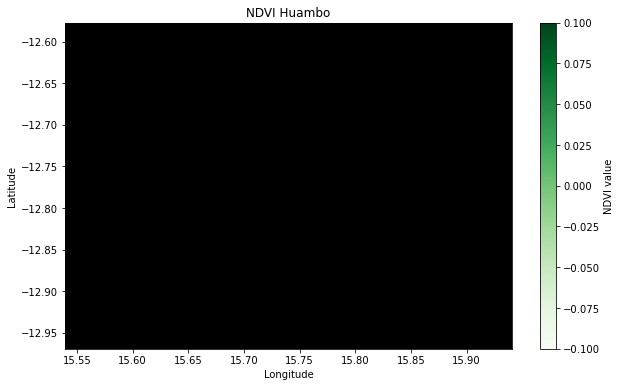

In [19]:
#NDVI
fig = plt.figure(figsize=(10, 6))
ax=plt.gca()

vi_df2 = vi_df.copy()
vi_df2.loc[(vi_df['pixel_reliability'] != 0) ,'NDVI'] = np.nan
vi_df2.loc[(vi_df['pixel_reliability'] != 0) ,'EVI'] = np.nan

x = vi_df2.Longitude
y = vi_df2.Latitude
NDVI = vi_df2.NDVI
EVI = vi_df2.EVI

#get the points into the correct format
X ,Y = np.meshgrid(x ,y)
Z = scipy.interpolate.griddata((x, y), NDVI, (X,Y), method='nearest')
palette = plt.cm.Greens
palette.set_bad(color = 'k', alpha = None)
c = ax.pcolormesh(X,Y, Z, cmap ='Greens', shading = 'auto')
fig.colorbar(c, ax=ax, label = 'NDVI value')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('NDVI {}'.format(City_name))

Text(0.5, 1.0, 'EVI Huambo')

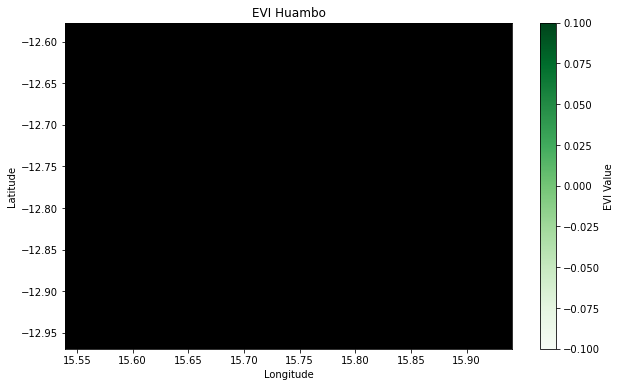

In [20]:
#EVI
fig = plt.figure(figsize=(10, 6))
ax=plt.gca()

Z = scipy.interpolate.griddata((x, y), EVI, (X,Y), method='nearest')

c = ax.pcolormesh(X,Y, Z, cmap ='Greens', shading = 'auto')
fig.colorbar(c, ax=ax, label = 'EVI Value')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('EVI {}'.format(City_name))

C:\Anaconda3\envs\project_environment\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))


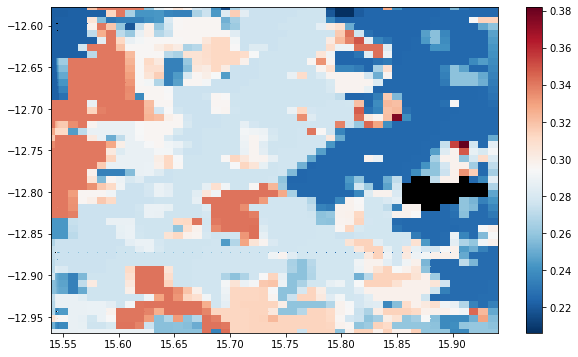

In [70]:
#NDVI
fig = plt.figure(figsize=(10, 6))
ax=plt.gca()

vi_df2 = vi_df.copy()
vi_df2.loc[(vi_df['Usefulness'] != '0') ,'NDVI'] = np.nan
vi_df2.loc[(vi_df['Usefulness'] != '0') ,'EVI'] = np.nan

x = vi_df2.Longitude
y = vi_df2.Latitude
NDVI = vi_df2.NDVI
EVI = vi_df2.EVI

#get the points into the correct format
X ,Y = np.meshgrid(x ,y)
Z = scipy.interpolate.griddata((x, y), NDVI, (X,Y))
#Zm = ma.array(Z,mask=np.isnan(Z))


palette = plt.cm.RdBu_r
palette.set_bad(color = 'k', alpha = None)
c = ax.pcolormesh(X,Y, Z, cmap = palette, vmin = NDVI.min(), vmax = NDVI.max(), shading = 'auto')

fig.colorbar(c, ax=ax)

C:\Anaconda3\envs\project_environment\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  # This is added back by InteractiveShellApp.init_path()


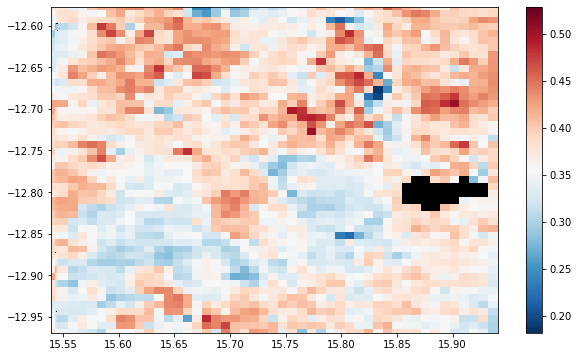

In [71]:
#EVI
fig = plt.figure(figsize=(10, 6))
ax=plt.gca()

#get the points into the correct format
X ,Y = np.meshgrid(x ,y)
Z = scipy.interpolate.griddata((x, y), EVI, (X,Y))
#Zm = ma.array(Z,mask=np.isnan(Z))

palette = plt.cm.RdBu_r
palette.set_bad(color = 'k', alpha = None)
c = ax.pcolormesh(X,Y, Z, cmap = palette, vmin = EVI.min(), vmax = EVI.max(), shading = 'auto')

fig.colorbar(c, ax=ax)

In [25]:
#loop through the aqua and terra datasets, add in average ndvi, evi, usefulness/ quality flags

#aqua
for i in range(len(vi_look_up_aqua)):
    #for each file
    vi_filename = vi_look_up_aqua['Filename'][i]    
    #open it/ generate dataframe
    df = vi_dataframe_create('MYD13A3', vi_filename)
    #find average ndvi, evi
    vi_look_up_aqua.loc[i, 'mean_NDVI']= df.NDVI.mean()
    vi_look_up_aqua.loc[i, 'mean_EVI'] = df.EVI.mean()
    #find the number of each quality check criteria 
    qc_list_flags = generate_qc_flags(df)
    #pixel_reliable_count
    vi_look_up_aqua.loc[i, 'pixel_reliable_count'] = qc_list_flags[0]
    #good_quality
    vi_look_up_aqua.loc[i, 'good_quality'] = qc_list_flags[1]
    #check_quality
    vi_look_up_aqua.loc[i, 'check_quality'] = qc_list_flags[2]
    #usefulness_0
    vi_look_up_aqua.loc[i, 'usefulness_0'] = qc_list_flags[3]
    #usefulness_1
    vi_look_up_aqua.loc[i, 'usefulness_1'] = qc_list_flags[4]

#save table 
#save the new df as a pickle
os.chdir(os.path.join('D:\\','MODIS_NDVI', CITY_COUNTRY))
pickle_name = 'aqua_IV_{}.pkl'.format(CITY_COUNTRY)
with open(pickle_name, 'wb') as f:
    pickle.dump(vi_look_up_aqua, f)
    
#terra
#vi_look_up_terra
for i in range(len(vi_look_up_terra)):
    #for each file
    vi_filename = vi_look_up_terra['Filename'][i]    
    #open it/ generate dataframe
    df = vi_dataframe_create('MOD13A3', vi_filename)
    #find average ndvi, evi
    vi_look_up_terra.loc[i, 'mean_NDVI']= df.NDVI.mean()
    vi_look_up_terra.loc[i, 'mean_EVI'] = df.EVI.mean()
    #find the number of each quality check criteria 
    qc_list_flags = generate_qc_flags(df)
    #pixel_reliable_count
    vi_look_up_terra.loc[i, 'pixel_reliable_count'] = qc_list_flags[0]
    #good_quality
    vi_look_up_terra.loc[i, 'good_quality'] = qc_list_flags[1]
    #check_quality
    vi_look_up_terra.loc[i, 'check_quality'] = qc_list_flags[2]
    #usefulness_0
    vi_look_up_terra.loc[i, 'usefulness_0'] = qc_list_flags[3]
    #usefulness_1
    vi_look_up_terra.loc[i, 'usefulness_1'] = qc_list_flags[4]

#save table 
#save the new df as a pickle
os.chdir(os.path.join('D:\\','MODIS_NDVI', CITY_COUNTRY))
pickle_name = 'terra_IV_{}.pkl'.format(CITY_COUNTRY)
with open(pickle_name, 'wb') as f:
    pickle.dump(vi_look_up_terra, f)

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

In [ ]:
#create a list of the urban mean evi and the rural mean evi
for m in range(len(CITY_COUNTRY_lat_lon)):

    CITY_COUNTRY = CITY_COUNTRY_lat_lon.CITY_COUNTRY[m]

    #load in the data with the list of the city vi files
    #get lists of all the VI files and their months/ years
    #TERRA
    SATELLITE_NDVI = 'MOD13A3'
    os.chdir(os.path.join('D:\\','MODIS_NDVI', CITY_COUNTRY, SATELLITE_NDVI))

    file_list = []
    month_list = []
    year_list = []
    for filename in os.listdir():
        if filename.endswith(".hdf"): 
            file_list.append(filename)
            yeardoy = filename.split('.')[1][1:]
            month_list.append(dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m'))
            year_list.append(dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y'))
            continue
        else:
            continue

    d = {'Filename': file_list, 'Month': month_list, 'Year': year_list}
    vi_look_up_terra = pd.DataFrame(data = d)

    #AQUA
    SATELLITE_NDVI = 'MYD13A3'
    os.chdir(os.path.join('D:\\','MODIS_NDVI', CITY_COUNTRY, SATELLITE_NDVI))

    file_list = []
    month_list = []
    year_list = []
    for filename in os.listdir():
        if filename.endswith(".hdf"): 
            file_list.append(filename)
            yeardoy = filename.split('.')[1][1:]
            month_list.append(dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m'))
            year_list.append(dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y'))
            continue
        else:
            continue

    d = {'Filename': file_list, 'Month': month_list, 'Year': year_list}
    vi_look_up_aqua = pd.DataFrame(data = d) 

    #Load in LULC data, these bases were created in JASMIN
    os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
    with open('UHI_Project_Pickle_Files\LULC_Pickles\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
         LULC_df = pickle.load(f)

    #create the df to be filled with the mean values
    vi_means_df = vi_means_df.rename(columns={"Filename": "Aqua_Filename"})
    vi_means_df['Terra_Filename'] = np.nan
    vi_means_df['rur_mean_evi'] = np.nan
    vi_means_df['urb_mean_evi'] = np.nan
    vi_means_df['pixel_reliability_percent'] = np.nan        
        
    for n in range(len(vi_means_df)):     
        #add the evi to the base
        #create the aqua and terra dataframes
        aqua_vi_file_name = vi_look_up_aqua.Filename[n]
        aqua_mon =  vi_look_up_aqua.Month[n]
        aqua_year = vi_look_up_aqua.Year[n]
        aqua_vi_df = vi_dataframe_create('MYD13A3', aqua_vi_file_name)

        terra_vi_file_name = vi_look_up_terra[(vi_look_up_terra.Month == aqua_mon) & (vi_look_up_terra.Year == aqua_year)].Filename.values[0]
        terra_vi_df = vi_dataframe_create('MOD13A3', terra_vi_file_name)

        #create a df containing final evi values (if aqua not reliable, use terra)
        LULC_df2 = LULC_df.copy()
        LULC_df2['aqua_evi'] = aqua_vi_df.EVI.values
        LULC_df2['aqua_pixel_reliability'] = aqua_vi_df.pixel_reliability.values
        LULC_df2['terra_evi'] = terra_vi_df.EVI.values
        LULC_df2['terra_pixel_reliability'] = terra_vi_df.pixel_reliability.values
        LULC_df2['evi_final'] = aqua_vi_df.EVI.values
        LULC_df2.loc[((LULC_df2['aqua_pixel_reliability'] == 1) & (LULC_df2['terra_pixel_reliability'] == 0)
                 ), 'evi_final'] = LULC_df2['terra_evi']
        LULC_df2['pixel_reliablity_final'] = 0
        LULC_df2.loc[((LULC_df2['aqua_pixel_reliability'] == 1) & (LULC_df2['terra_pixel_reliability'] == 1)
                 ), 'pixel_reliablity_final'] = 1

        #calculate the average rur/ urb evi and pixel reliability percent
        rur_mean_evi = LULC_df2[(LULC_df2['pixel_reliablity_final'] == 0)&(LULC_df2['lccs_class_overall_2015'] != 190
                                                                      )].evi_final.mean()
        urb_mean_evi = LULC_df2[(LULC_df2['pixel_reliablity_final'] == 0)&(LULC_df2['lccs_class_overall_2015'] == 190
                                                                      )].evi_final.mean()
        pixel_reliability_percent = 100* len(LULC_df2[(LULC_df2['pixel_reliablity_final'] == 0)])/ len(LULC_df2)

        #add to the overall dataframe with the list of files and the means
        vi_means_df.loc[n,'Terra_Filename'] = terra_vi_file_name
        vi_means_df.loc[n,'rur_mean_evi'] = rur_mean_evi
        vi_means_df.loc[n,'urb_mean_evi'] = urb_mean_evi
        vi_means_df.loc[n,'pixel_reliability_percent'] = pixel_reliability_percent

    #save the df
    os.chdir(os.path.join('D:\\','MODIS_NDVI', CITY_COUNTRY))
    pickle_name = 'vi_means_df_{}.pkl'.format(CITY_COUNTRY)
    with open(pickle_name, 'wb') as f:
        pickle.dump(vi_means_df, f)

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\project_environment\lib\site-packages\rasterio\__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Anaconda3\envs\pr

In [80]:
vi_means_df

,Aqua_Filename,Month,Year,Terra_Filename,rur_mean_evi,urb_mean_evi,pixel_reliability_percent
0,MYD13A3.A2002182.h19v10.006.2015154143627.hdf,07,2002,MOD13A3.A2002182.h19v10.006.2015149185920.hdf,0.167035,0.175321,99.376392
1,MYD13A3.A2002213.h19v10.006.2015150083433.hdf,08,2002,MOD13A3.A2002213.h19v10.006.2015150204711.hdf,0.164223,0.158624,18.975501
2,MYD13A3.A2002244.h19v10.006.2015151113359.hdf,09,2002,MOD13A3.A2002244.h19v10.006.2015151082622.hdf,0.219191,0.171443,22.850780
3,MYD13A3.A2002274.h19v10.006.2015152043021.hdf,10,2002,MOD13A3.A2002274.h19v10.006.2015152041810.hdf,0.227876,0.185075,8.017817
4,MYD13A3.A2002305.h19v10.006.2015153092025.hdf,11,2002,MOD13A3.A2002305.h19v10.006.2015152182552.hdf,0.285098,0.217433,48.775056
...,...,...,...,...,...,...,...
215,MYD13A3.A2020214.h19v10.006.2020260222236.hdf,08,2020,MOD13A3.A2020214.h19v10.006.2020261220824.hdf,0.174494,0.141456,65.790646
216,MYD13A3.A2020245.h19v10.006.2020289195141.hdf,09,2020,MOD13A3.A2020245.h19v10.006.2020291075309.hdf,0.190657,0.186300,11.848552
217,MYD13A3.A2020275.h19v10.006.2020315004016.hdf,10,2020,MOD13A3.A2020275.h19v10.006.2020321232753.hdf,0.226765,NaN,5.033408
218,MYD13A3.A2020306.h19v10.006.2020347040113.hdf,11,2020,MOD13A3.A2020306.h19v10.006.2020338061850.hdf,0.318558,0.200980,75.812918


In [82]:
vi_look_up_aqua

,Filename,Month,Year
0,MYD13A3.A2002182.h13v10.006.2015154143708.hdf,07,2002
1,MYD13A3.A2002213.h13v10.006.2015150083431.hdf,08,2002
2,MYD13A3.A2002244.h13v10.006.2015151113402.hdf,09,2002
3,MYD13A3.A2002274.h13v10.006.2015152043813.hdf,10,2002
4,MYD13A3.A2002305.h13v10.006.2015153093954.hdf,11,2002
...,...,...,...
219,MYD13A3.A2020275.h13v10.006.2020315002641.hdf,10,2020
220,MYD13A3.A2020306.h13v10.006.2020347040022.hdf,11,2020
221,MYD13A3.A2020336.h13v10.006.2021009225006.hdf,12,2020
222,MYD13A3.A2021001.h13v10.006.2021042003631.hdf,01,2021
